### Import packages

In [3]:
import pandas as pd                                                       # dataframes lib
import numpy as np                                                        # linear algebra lib
import re                                                                 # regex lib
import matplotlib.pyplot as plt                                           # plotting lib 
import seaborn as sns                                                     # ext plotting lib
from sklearn.decomposition import PCA, TruncatedSVD                       # dimensionality reduction module
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering       # sklearn clustering algorithms
from sklearn.feature_extraction.text import TfidfVectorizer               # tf-idf lib for text
from sklearn.metrics import adjusted_rand_score, silhouette_score         # evaluating clustering
from sklearn.metrics.pairwise import cosine_similarity                    # cosine similarity module
import hdbscan                                                            # hdbscan clustering algo
import nltk                                                               # Nat Lang Processing package
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer   # NLTK tokenization modules
from nltk.corpus import stopwords                                         # NLTK stop words  
from nltk.stem.wordnet import WordNetLemmatizer                           # NLTK lemmitization lib
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))                              # NLTK stopwords set

[nltk_data] Downloading package stopwords to /home/becode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/becode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/becode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in test-A tsv file

Read kleister test-A tsv file into dataframe; only using 'text_tesseract' OCR column

In [4]:
# read kleister test-A tsv file into dataframe; only using 'text_tesseract' OCR column

kl = pd.read_csv('/home/becode/AI/Data/Faktion/kleister-charity/test-A/in.tsv', sep='\t',
            names=['filename', 'keys', 'text_djvu', 'text_tesseract', 'text_textract', 'text_best'], 
            usecols=['filename','text_tesseract'])
print(kl.head(5))

                               filename  \
0  abbf98ed31e28068150dce58296302ee.pdf   
1  f3e363848aea2fa645814f2de0221a5a.pdf   
2  62acdd1bbd0dfeea27da2720eb795449.pdf   
3  e734bc7dfc9b37c5dd2c3a37693062e8.pdf   
4  cb6b0949a2f9294750e436f7ea2f10ce.pdf   

                                      text_tesseract  
0  \n0 r = - ’ AT \ PRAESTAT OPES SAPIENTIA HAMPT...  
1  Charity Registration No. 1076498\nCompany Regi...  
2  LU O  \nSection A\nReport to the trustees/memb...  
3  \n \no \\nPe - scno®\nBreachwood Green Pre-Sch...  
4  5\nbishops stortford baptist church\nBishop’s ...  


In [5]:
# check for 'exact' document duplicates in the OCR column, there are apparently none.
kl.duplicated(subset=['text_tesseract'], keep=False)
print(kl.text_tesseract[kl.duplicated(['text_tesseract'])==True])

Series([], Name: text_tesseract, dtype: object)


In [6]:
# some easy preprocessing after looking at text content
kl['text_tesseract'] = kl['text_tesseract'].astype(str)
kl['text_tesseract'] = kl['text_tesseract'].apply(lambda x: x.replace("\n",""))
kl['text_tesseract'] = kl['text_tesseract'].apply(lambda x: x.replace("\\n",""))

### TF-IDF vectorization of tokenized text

TF-IDF or term frequency - inverse document frequency; Tf*Idf

TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document 
in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears
in the document and is offset by the number of documents in the corpus that contain the word, 
which helps to adjust for the fact that some words appear more frequently in general.

Our text needs to be tokenized/processed and vectorised to cluster documents in groups with similar templates. From the vectorised text we can also calculate cosine similarity between documents, a metric to determine sililarity between documents.


We will call Sci-kit Learn's ```tfidf_vectorizer``` and tokenize with the function below

In [7]:
# Tokenize or more specifically lemmitize sentence and word
def tokenize_lem(text):
    lem = WordNetLemmatizer()
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.match('[a-zA-Z]', token) and not token in stop_words and len(token)>3: # changed from if re.search('[a-zA-Z]', token)
            lemmatized_word = lem.lemmatize(token)
            filtered_tokens.append(lemmatized_word)
    return filtered_tokens

In [8]:
# Call tfidf_vectorizer with params -> point to 'tokenize_lem' func which lemmatizes and removes stop words
tfidf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 0,max_features=5000, stop_words=None,
                                   use_idf=True, tokenizer=tokenize_lem, norm='l2') #, ngram_range=(1,3))
# fit vectorizer and transform documents' text content to vectors
X = tfidf_vectorizer.fit_transform(kl['text_tesseract']) 
print(X.shape)
X.todense() # turn sparse matrix to dense

(609, 5000)


matrix([[0.        , 0.        , 0.00398023, ..., 0.        , 0.        ,
         0.00431002],
        [0.        , 0.        , 0.00768305, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.00806259, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02845581, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.00735128, ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
print(X.toarray())
df1 = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
print(df1)

print(tfidf_vectorizer.vocabulary_)
print(len(tfidf_vectorizer.vocabulary_))

### Cosine similarity matrix

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. 
It is defined to equal the cosine of the angle between them,
which is also the same as the inner product of the same vectors normalized to both have length 1. 
A cosine similarity of 0 means that the angle between two vectors equals 90 deg and the documents are not similar at all. A value of 1, or angle of 0 deg, means that the documents are the same.
High cosine similarity values represent similar documents.

#### Calculate or use Sci-kit learn ```cosine_similarity(X)```

In [9]:
#cosine similarity matrix 
cosim = (X * X.T).toarray()
print(cosim)
print(cosim.shape)
print(np.count_nonzero(cosim>=1))
print(np.count_nonzero(cosim>=0.99999))

[[1.         0.38119838 0.04801843 ... 0.08710477 0.08342413 0.05008817]
 [0.38119838 1.         0.06218071 ... 0.14903357 0.13470201 0.07812647]
 [0.04801843 0.06218071 1.         ... 0.07560679 0.1151121  0.04693034]
 ...
 [0.08710477 0.14903357 0.07560679 ... 1.         0.16678916 0.10187914]
 [0.08342413 0.13470201 0.1151121  ... 0.16678916 1.         0.08882642]
 [0.05008817 0.07812647 0.04693034 ... 0.10187914 0.08882642 1.        ]]
(609, 609)
320
613


In [10]:
np.max(cosim)

1.0000000000000073

In [44]:
cosim[cosim>0.8]

array([1.        , 0.96998711, 1.        , ..., 1.        , 0.98139171,
       1.        ])

In [11]:
ind = list(zip(*np.where(cosim>0.8)))
def remove_same(ind):
    for item in ind:
        if item[0]==item[1]:
            ind.remove(item)
    return(ind)
remove_same(ind)

[(0, 545),
 (1, 227),
 (1, 586),
 (2, 69),
 (2, 588),
 (3, 490),
 (4, 406),
 (5, 594),
 (6, 593),
 (7, 172),
 (7, 405),
 (8, 105),
 (8, 498),
 (9, 384),
 (10, 512),
 (12, 12),
 (12, 407),
 (13, 489),
 (14, 531),
 (15, 591),
 (16, 360),
 (16, 581),
 (17, 468),
 (18, 402),
 (19, 102),
 (19, 244),
 (19, 480),
 (21, 21),
 (21, 218),
 (21, 579),
 (22, 556),
 (23, 458),
 (24, 514),
 (25, 66),
 (25, 555),
 (26, 145),
 (26, 453),
 (27, 63),
 (27, 382),
 (27, 563),
 (28, 57),
 (28, 367),
 (28, 434),
 (29, 95),
 (29, 533),
 (30, 590),
 (31, 338),
 (31, 396),
 (32, 486),
 (34, 34),
 (34, 343),
 (34, 525),
 (36, 36),
 (37, 456),
 (38, 427),
 (39, 575),
 (40, 467),
 (41, 503),
 (42, 359),
 (44, 44),
 (46, 46),
 (46, 415),
 (47, 375),
 (47, 429),
 (49, 49),
 (49, 233),
 (49, 363),
 (49, 558),
 (50, 550),
 (51, 536),
 (52, 334),
 (53, 385),
 (53, 447),
 (54, 322),
 (55, 349),
 (55, 587),
 (56, 234),
 (56, 482),
 (57, 28),
 (57, 367),
 (57, 434),
 (58, 539),
 (59, 138),
 (59, 336),
 (59, 566),
 (60, 4

In [12]:
kl_ind = []
for item in ind:
    kl_ind.append([kl.loc[item[0], 'filename'],kl.loc[item[1], 'filename']])
kl_ind

[['abbf98ed31e28068150dce58296302ee.pdf',
  'a664201601ef7decfa90b498b9744f6b.pdf'],
 ['f3e363848aea2fa645814f2de0221a5a.pdf',
  '68f051458160813b409d44ab6290592f.pdf'],
 ['f3e363848aea2fa645814f2de0221a5a.pdf',
  'd4e8f8c69b9c48e59d39bdccf3dfdab6.pdf'],
 ['62acdd1bbd0dfeea27da2720eb795449.pdf',
  '77adf430a8c6c6abca4149bc928761b9.pdf'],
 ['62acdd1bbd0dfeea27da2720eb795449.pdf',
  '40a55dc4f0e98eee100f4b8aa59a1f14.pdf'],
 ['e734bc7dfc9b37c5dd2c3a37693062e8.pdf',
  '15ea60f1e1a9157a4a8f7788da9fb152.pdf'],
 ['cb6b0949a2f9294750e436f7ea2f10ce.pdf',
  '8f8aa898aef8e757c2caa83475e85eac.pdf'],
 ['87c977ccb9bdf111b1397e9c4ada2470.pdf',
  '883929b72ee6f652da94f83adc0be0e7.pdf'],
 ['39df988309a04c631445b04ebd6a4a53.pdf',
  '4c3937a1f36ef0f1f9ce1cbf650355e5.pdf'],
 ['e38bd1524e145b49edf991ab8f3e153d.pdf',
  '82c13c9bd0c16cd1dc48dce1ed401578.pdf'],
 ['e38bd1524e145b49edf991ab8f3e153d.pdf',
  '0e4c6144f9bcc22c58c817427b60b620.pdf'],
 ['bb80583ada5875ccb4690ffa22f97bab.pdf',
  '14c2328530908171da13

In [13]:
hi,bi = np.histogram(cosim,bins=10)

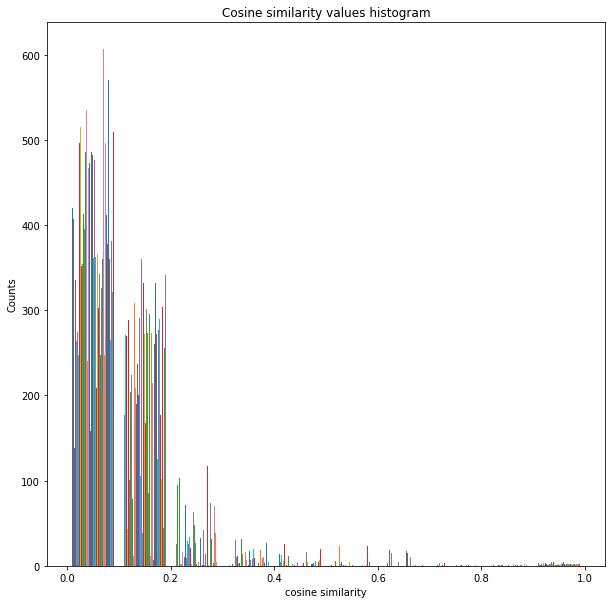

In [17]:
plt.figure(figsize=(10,10))
plt.hist(cosim,bi)
plt.title('Cosine similarity values histogram')
plt.xlabel('cosine similarity')
plt.ylabel('Counts')
plt.savefig('histogram_cosim.png')
plt.show()

In [11]:
print(np.count_nonzero(cosim >= 1))
print(np.count_nonzero(cosim > 1))
print(np.count_nonzero(cosim == 1))
print(np.count_nonzero(cosim >= 0.999999))
print(np.count_nonzero(cosim > 0.999999))
adj_cosim = cosim.copy()
np.fill_diagonal(adj_cosim, 0) # remove 1's on diagonal
ones = list(zip(*np.where(adj_cosim>0.999999)))
ones = remove_dup(ones)
print(ones)
kl_ones = []
for item in ones:
    kl_ones.append([kl.loc[item[0], 'filename'],kl.loc[item[1], 'filename'], adj_cosim[item[0],item[1]]])
print(kl_ones)
max_cosim = adj_cosim.max(axis=0)
#print(max_cosim)

320
268
52
613
613
[(141, 574), (162, 553)]
[['6b15787e2654b725f2bfc86da7dea511.pdf', 'e7d861735330f70a05d0aa51a5a4b096.pdf', 0.9999999999999989], ['efac1f09a642532db1fb18b63e1f13b1.pdf', '5d06055f6a4b58260fe2dcf6871db799.pdf', 0.9999999999999994]]


#### 6b15787e2654b725f2bfc86da7dea511.pdf and e7d861735330f70a05d0aa51a5a4b096.pdf are two documents from The Housley Bequest Limited that are exactly identical but for the year of the report and the actual numbers. 
#### 5d06055f6a4b58260fe2dcf6871db799.pdf and efac1f09a642532db1fb18b63e1f13b1.pdf are two identical fiancial reports for year 2015, only the ordering of two pages is slighty different, once at start of document, once at the end.

In [12]:
print(np.count_nonzero((adj_cosim >= 0.9) & (adj_cosim < 0.99999)))
print(np.count_nonzero((adj_cosim >= 0.9) & (adj_cosim < 0.999)))
print(np.count_nonzero((adj_cosim >= 0.9) & (adj_cosim < 0.99)))
print(np.count_nonzero((adj_cosim >= 0.99) & (adj_cosim < 0.99999)))
print(np.count_nonzero((adj_cosim >= 0.95) & (adj_cosim < 0.99999)))
print(np.count_nonzero((adj_cosim >= 0.9) & (adj_cosim < 0.95)))
print(np.count_nonzero((adj_cosim >= 0.8) & (adj_cosim < 0.99999)))
print(np.count_nonzero((adj_cosim >= 0.8) & (adj_cosim < 0.9)))

486
486
470
16
240
246
706
220


In [10]:
# remove same combos in list w/ tuples, i.e. (41,503) and (503,41):
def remove_dup(lst):
    temp = []
    for item in lst:
        if item[::-1] not in temp:
            temp.append(item)
    lst = temp
    return lst

In [13]:
u = list(zip(*np.where((adj_cosim >= 0.99) & (adj_cosim < 0.99999))))
print(u, len(u))
u = remove_dup(u)
print(u, len(u))
kl_u = []
for item in u:
    kl_u.append([kl.loc[item[0], 'filename'], kl.loc[item[1], 'filename'], adj_cosim[item[0],item[1]]])
print(kl_u)
print(len(kl_u))

[(41, 503), (67, 532), (69, 588), (90, 583), (201, 400), (215, 386), (232, 577), (281, 603), (386, 215), (400, 201), (503, 41), (532, 67), (577, 232), (583, 90), (588, 69), (603, 281)] 16
[(41, 503), (67, 532), (69, 588), (90, 583), (201, 400), (215, 386), (232, 577), (281, 603)] 8
[['1c2c152684f80a18731d702e511688a1.pdf', '8d8ffb8e362a84bc88abc5b13b0d93d0.pdf', 0.9959724522619563], ['5b04abbb5217453def3b902b2febc615.pdf', '1ab427986501fbcc8cc896bebff53e50.pdf', 0.990493392720965], ['77adf430a8c6c6abca4149bc928761b9.pdf', '40a55dc4f0e98eee100f4b8aa59a1f14.pdf', 0.9921774981813456], ['d74b2d867ccd9d4c5a338734f54f186b.pdf', 'db433bc3ee996848291825084ed085b6.pdf', 0.9910851378242008], ['fcbdf4902d68b324b2b905791e7f2aa4.pdf', 'bc61a0796eea8dc0e8be6162fe0e8e83.pdf', 0.9976519309967238], ['40a8fe34fd3f986eb11836a141f500f3.pdf', 'd3e0e1547629d5fa2171b4d33d0e1d41.pdf', 0.9912788944782498], ['a4aff0455e1c01f0181615677d2b6ae0.pdf', 'b0af6cbff59ac690a9fc1dbcbf9889c2.pdf', 0.9971861666427051], ['b

In [14]:
v = list(zip(*np.where((adj_cosim >= 0.95) & (adj_cosim < 0.99999))))
v = remove_dup(v)
kl_v = []
for item in v:
    kl_v.append([kl.loc[item[0], 'filename'], kl.loc[item[1], 'filename'], adj_cosim[item[0],item[1]]])
print(kl_v)
print(len(kl_v))

[['abbf98ed31e28068150dce58296302ee.pdf', 'a664201601ef7decfa90b498b9744f6b.pdf', 0.9699871073217092], ['f3e363848aea2fa645814f2de0221a5a.pdf', '68f051458160813b409d44ab6290592f.pdf', 0.9809504504409121], ['e734bc7dfc9b37c5dd2c3a37693062e8.pdf', '15ea60f1e1a9157a4a8f7788da9fb152.pdf', 0.9750591521327265], ['87c977ccb9bdf111b1397e9c4ada2470.pdf', '883929b72ee6f652da94f83adc0be0e7.pdf', 0.9808187825158251], ['bb80583ada5875ccb4690ffa22f97bab.pdf', 'f15bdc3bb0a44c197b6219d21adf61bb.pdf', 0.978521945030226], ['2a1e0d3371835da70449eca9a93df0cf.pdf', '684e80bed275a44422edc4daf9aa6f20.pdf', 0.9550090758568538], ['5ca7d4dbb023922f49e741d81821b689.pdf', '71a1e62cf03f075894ed16bccafde4be.pdf', 0.9602481074744834], ['bff61c08324138f11c06e0e5fbf8dc98.pdf', '710ab19d5dd7379d1deec7df584c5ec8.pdf', 0.9784514692800378], ['a5c40991580e19fa0effc99c3bb70eed.pdf', '54470c00e3b15d15017ab7c6933e1b05.pdf', 0.9611134204162997], ['a5c40991580e19fa0effc99c3bb70eed.pdf', '956a49699dbbecb102f784c6f0cc9a26.pdf', 0

In [59]:
609**2

370881

### Looking for documents with little max cos similarity

In [15]:
maxi = np.max(adj_cosim,axis=0)
print(np.where(maxi < 0.5)) # document index
print(np.where((maxi >= 0.4) & (maxi < 0.5)))
print(np.where((maxi >= 0.3) & (maxi < 0.4)))
print(np.where((maxi >= 0.2) & (maxi < 0.3)))
print(np.where((maxi >= 0.1) & (maxi < 0.2)))
print(np.where(maxi < 0.1))

(array([ 44,  45,  48,  81, 118, 157, 199, 238, 239, 248, 254, 256, 258,
       259, 260, 263, 264, 265, 266, 267, 269, 272, 273, 274, 275, 276,
       278, 279, 280, 283, 284, 285, 288, 289, 290, 291, 293, 294, 296,
       299, 301, 303, 304, 306, 307, 308, 311, 313, 314, 316, 317, 323,
       326, 327, 329, 332, 390, 391, 430, 599, 601, 607]),)
(array([238, 256, 259, 264, 265, 266, 274, 283, 291, 296, 299, 329, 391,
       599]),)
(array([ 45,  48, 199, 248, 258, 260, 267, 272, 273, 276, 278, 279, 284,
       288, 289, 293, 301, 303, 306, 307, 308, 314, 317, 323, 327, 332,
       390, 601, 607]),)
(array([ 44,  81, 118, 157, 239, 254, 263, 275, 280, 290, 294, 311, 313,
       326]),)
(array([269, 285, 304, 430]),)
(array([316]),)


In [16]:
#print(np.where(maxi < 0.5)) # document index
a = np.where((maxi >= 0.4) & (maxi < 0.5))#[0]
a = a[0].tolist()
b = np.where((maxi >= 0.3) & (maxi < 0.4))
c = np.where((maxi >= 0.2) & (maxi < 0.3))
d = np.where((maxi >= 0.1) & (maxi < 0.2))
e = np.where(maxi < 0.1)
b = b[0].tolist()
c = c[0].tolist()
d = d[0].tolist()
e = e[0].tolist()

print(a,"\n",b,"\n",c,"\n",d,"\n",e)

[238, 256, 259, 264, 265, 266, 274, 283, 291, 296, 299, 329, 391, 599] [45, 48, 199, 248, 258, 260, 267, 272, 273, 276, 278, 279, 284, 288, 289, 293, 301, 303, 306, 307, 308, 314, 317, 323, 327, 332, 390, 601, 607] [44, 81, 118, 157, 239, 254, 263, 275, 280, 290, 294, 311, 313, 326] [269, 285, 304, 430] [316]


In [17]:
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
print(list(map(file,b)),"\n")
print(list(map(file,c)),"\n")
print(list(map(file,d)),"\n")
print(list(map(file,e)))

['12795a92330c7ee5ab6cff74fca69af3.pdf', '31b42fe20da84260dd84642e210fe8da.pdf', 'a25839ee3e8a4f123c4e497665e23404.pdf', '0854970f40425f8933211b155e8562ab.pdf', 'bedbb8bb3ceeff997e46619860d63c24.pdf', 'c20a06364ef15a6460a754126c6a13e6.pdf', '499f8611b75238712f82a2b0f5efbae7.pdf', '5607274d851ebd46aa0a904a27867d3e.pdf', '8d3852e5837934098fc721d6a661a859.pdf', 'f6f7a380685c31ce7a0c9bde3c113b4b.pdf', 'fb7d5f36390d3b8b59e9dccce56f7edf.pdf', 'f504f232284dd4404383e1d8b0790d3b.pdf', 'b9af54d407630bd267f94980d9613d23.pdf', '039c79ba713fd703bb22056f295302bd.pdf'] 

['4aab8832280966c9909e45de7d3e0945.pdf', 'd4f76109b16fe600beaada478c180f75.pdf', '36e73c36540186d770a986c87f898dc4.pdf', 'cd48db24eca35e89857eb4a2029300f6.pdf', '2f4c0e58f5c4a80aa63133649cd9be14.pdf', '6f6455ca99e1b5fa504f57b211b6fd1e.pdf', '86feb654881d07e89dc84d40ac6bea93.pdf', '0d07eced3d0845f1c2277a6518c8a607.pdf', '7c87c12305f2fbfeb9543007f6487b5d.pdf', '01e6b284fb4f60febef3671570bb1f48.pdf', '7535bcb4fe1ad36085085d269e3a88e6.pd

#### 'b57e1ae7a9f286733362fa87fa704543.pdf' is a document with the lowest max cosine sim < 0.1, it appears to be a document that was scanned upside down

In [18]:
print(kl[kl['filename'] == 'b57e1ae7a9f286733362fa87fa704543.pdf']['text_tesseract'].values[0:120])

['wd(g L 1e ST0T YT ,01 U0daysdoayg ‘3rodmoaN ‘puowispy‘AyIsaaAru) swepy JdaeH ‘wooy pieog a9y L.Je PPRY3q oLONLLHAN "TVHANTD TVIINNYJO 30NPSINAWALVLS TVIONVNIApueLIOdTA TVANNVNoopper) £V IJJUIPISAA]ALAIDOS "TVINLINDI-IOVLOTALSIA ANV LAOdMAHNJIewaoyS (1 IA IOUIQAR], [ SINA1p12.4102§ 2UIUD)) AUD32.4028 [DANININIOHSprempd ¥A 1IN [TeH 4 1INA1032.4028 2510 A1D12.4028 YI01S2A1]piod Hf TN [TeH N 1INA24NSDIA ], LADIOUOF] Juap1sa4g 2214Y00 MOUSHIOdMIT MMM 19)IS QIA\\ST 00 MOUSHOdMAUB)OFUT : [IRTUEeS8 (Ts610) -xeq¥18018 (TS610) :IPLanysdoays1odmaNSMOTA] 1ONIBIA T[[PLR] AD SIN }20ppe) [V INLISDUDY MOYS JuUIPIS24gsjoejuo)$T0Z T2QUIII( € PIPUD 18IA ) 10]sjudwd)e)S [erodueur pue Jaoday enuuy"SISBQ POAIDS ISII ‘QUI0D ISIIJ B UO PIOS 2q [[IM ‘Aue JI ‘9jep jey) Je d[qe[reae [[Us sofeyoed diysioquiowrpue G[(g dunf 6] UO ISO[d 2I0JaIaY} [[Im drgsroquiowr 10y suonedrddy "¢z 10§ sroqunu diysoquiowJWI[ 0] POpPIodp Sey ARI00S dY} ‘POPMOIOIOAO SUWI0ID] JOU Op SINI[IOR] ABP MOUS 1BY) 9INSUS OF,*9)1sqam s 1910

### Query n most similar documents for a given document

Query n most similar documents for a given filename from 'kl' dataframe (with OCR column and filename), and cosine similarity matrix 'cosim' after vectorisation of 'kl' OCR column with TF-IDF

In [131]:
def query_sim(doc:str, n:int)->list:
    # filename must be valid and existing and the range of documents to query must be shape-1
    if re.search('(.).pdf',doc) and doc in kl.filename.tolist() and n in range(kl.shape[0]-1): 
        ind = kl[kl['filename'] == doc].index.values # get index document filename in dataframe
        row = cosim[ind,:] # retrieve the row from cosine similarity matrix for that filename
        sort = np.argsort(row)[0] # sort that row
        n_high = sort[-(n+1):].tolist() # sorted ascending; so take last n+1 largest elements and make list
        n_high.remove(ind) # remove cosine similarity value of 1, of the element with itself, n elem remain
        sims = {}
        # iterate reversed list n_high; from greater to smaller cosine similarity values
        for item in n_high[::-1]:
            sims[kl.iloc[item]['filename']] = cosim[ind,item][0]
        #create dataframe because it looks nice, but dictionary above already contains all information
        sim_docs = pd.DataFrame({'document' : sims.keys(),'cosine similarity': sims.values()})
    else:
        sim_docs = []
        print(f'not a valid document name')
    return sim_docs

In [132]:
query_sim('8a432d5358e8fb9b20c78146be11bfe6.pdf', 10)

,document,cosine similarity
0,2ee7a564d4f89e3d405fc60685b797a0.pdf,0.147202
1,f584b41b0a066c235cb8ceeea5adf78d.pdf,0.135130
2,dd3c82eefc3dc0efd3ed9ecc88f5b5f4.pdf,0.131975
3,129ca59a03ae79cb3afe0379f5190c18.pdf,0.129909
4,1b38166410e33b41c8947b446b07ae43.pdf,0.129113
5,de3a3c9c5948f93b228e14b6605a3720.pdf,0.128181
6,566282ace9d2e110a0f3176755c1a51c.pdf,0.125027
7,fb7d5f36390d3b8b59e9dccce56f7edf.pdf,0.124939
8,6ec0c38b03264cf41f6d72fda7c5bc6a.pdf,0.123672
9,d89950ef5ca21b540e12cf234ab5ca72.pdf,0.119761
